In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from training.util import sgd, plot_losses, adam, lr_scheduler, wilson_scheduler

/home/flo/anaconda3/envs/bdl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
import experiments.base.cifar as cifar

batch_size = 128
trainloader = cifar.cifar10_trainloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size, subsample=5000)
testloader = cifar.cifar10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=batch_size)
#stl_testloader = cifar.stl10_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size=128)

In [7]:
import experiments.base.cifar as cifar
corrupted_testloader = cifar.cifar10_corrupted_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", intensity=4, batch_size=128)

: 

: 

In [4]:
from training.pp import MAP
from training.swag import SwagModel

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

config = {
    "deviation_samples": 30,
    "mean_samples": 100,
    "start_epoch": 161
}

model = MAP(layers)

model.train_model(30, torch.nn.NLLLoss(), sgd(1e-1, weight_decay=3e-4, momentum=0.9, nesterov=True), trainloader, batch_size, device, scheduler_factory=wilson_scheduler(161, 0.1, None))
#model.load_state_dict(torch.load("/mnt/d/Uni/Bachelorarbeit/results/CIFAR10/2/results/MAP/log/rep_00model.tar"))
model.to(device)

Epoch 0: loss 2.01584792137146
Epoch 1: loss 1.7863575220108032
Epoch 2: loss 1.6391899585723877
Epoch 3: loss 1.5623986721038818
Epoch 4: loss 1.491809368133545
Epoch 5: loss 1.3847906589508057
Epoch 6: loss 1.335707426071167
Epoch 7: loss 1.2436728477478027
Epoch 8: loss 1.1986472606658936
Epoch 9: loss 1.2174004316329956
Epoch 10: loss 1.1391068696975708
Epoch 11: loss 1.0604826211929321
Epoch 12: loss 1.0955108404159546
Epoch 13: loss 1.040108323097229
Epoch 14: loss 0.9668388366699219
Epoch 15: loss 0.9387396574020386
Epoch 16: loss 0.8718662261962891
Epoch 17: loss 0.86735999584198
Epoch 18: loss 1.076339840888977
Epoch 19: loss 0.9016361236572266
Epoch 20: loss 0.8792597055435181
Epoch 21: loss 0.931921660900116
Epoch 22: loss 0.8573635220527649
Epoch 23: loss 0.8128498792648315
Epoch 24: loss 0.7687486410140991
Epoch 25: loss 0.7544850707054138
Epoch 26: loss 0.7607107162475586
Epoch 27: loss 0.8008245229721069
Epoch 28: loss 0.82341468334198
Epoch 29: loss 0.7128819227218628
F

MAP(
  (model): Sequential(
    (0): PreResNet(
      (model): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PreBasicBlock(
          (main_path): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (4): ReLU()
            (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (skip_path): Identity()
        )
        (2): PreBasicBlock(
          (main_path): Sequential(
            (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
            (1): ReLU()
            (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (3

In [5]:
import experiments.base.multiclass_classification as exp

exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.5697000026702881
 Avg Log Likelihood: -1.3590730428695679
 Avg Likelihood: 0.5061303973197937
 ECE: 0.14759075942486524


(tensor(0.5697),
 tensor(-1.3591),
 tensor(0.5061),
 <training.calibration.ClassificationCalibrationResults at 0x7fd4b9326f70>)

In [5]:
from training.bbb import BBBModel, GaussianPrior

prior = GaussianPrior(torch.tensor(0), torch.tensor(1))
layers = [
    ("variational-preresnet-20", (32, 3, 10, prior)),
    ("logsoftmax", ())
]

model = BBBModel(layers)

model.train_model(120, torch.nn.NLLLoss(), sgd(5e-1), trainloader, batch_size, device, scheduler_factory=lr_scheduler([80, 120], 0.1), mc_samples=2, kl_rescaling=0.5)

Epoch 0: loss 0.017442939803004265
Epoch 1: loss 0.01576991006731987
Epoch 2: loss 0.014974778518080711
Epoch 3: loss 0.014475700445473194
Epoch 4: loss 0.014159495010972023
Epoch 5: loss 0.013932622969150543
Epoch 6: loss 0.01374245434999466
Epoch 7: loss 0.013229833915829659
Epoch 8: loss 0.012925120070576668
Epoch 9: loss 0.012771576642990112
Epoch 10: loss 0.012399147264659405
Epoch 11: loss 0.012389701791107655
Epoch 12: loss 0.01197140384465456
Epoch 13: loss 0.01222048420459032
Epoch 14: loss 0.011660674586892128
Epoch 15: loss 0.011697755195200443
Epoch 16: loss 0.011239136569201946
Epoch 17: loss 0.01122136041522026
Epoch 18: loss 0.01112551148980856
Epoch 19: loss 0.01108136959373951
Epoch 20: loss 0.010432997718453407
Epoch 21: loss 0.010588743723928928
Epoch 22: loss 0.010188398882746696
Epoch 23: loss 0.010154985822737217
Epoch 24: loss 0.00992424413561821
Epoch 25: loss 0.009830254130065441
Epoch 26: loss 0.009538568556308746
Epoch 27: loss 0.009470631368458271
Epoch 28: 

In [ ]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, corrupted_testloader, device)

tensor(0.5264)
 Accuracy: 0.37957367300987244
 Avg Log Likelihood: -2.0528364181518555
 Avg Likelihood: 0.30053094029426575
 ECE: 0.146800649462405


(tensor(0.3796),
 tensor(-2.0528),
 tensor(0.3005),
 <training.calibration.ClassificationCalibrationResults at 0x7fcc00161f70>)

In [6]:
import experiments.base.multiclass_classification as exp

exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.6556000113487244
 Avg Log Likelihood: -1.1313354969024658
 Avg Likelihood: 0.5835703611373901
 ECE: 0.08731313892900944


(tensor(0.6556),
 tensor(-1.1313),
 tensor(0.5836),
 <training.calibration.ClassificationCalibrationResults at 0x7f272b4afb20>)

In [12]:
from training.pp import MAP
from training.vogn import iVONModuleFunctorch, VOGNModule

layers = [
    ("preresnet-20", (32, 3, 10)),
    ("logsoftmax", ())
]

ivon_model = iVONModuleFunctorch(layers)
ivon_model.train_model(30, torch.nn.NLLLoss(), {"lr": 1e-1, "prior_prec": 10, "betas": (0.9, 0.999), "damping": 1e-3, "augmentation": 5, "sample": True}, trainloader, batch_size, device, scheduler=wilson_scheduler(30, 1e-1, None, functional=True), mc_samples=2)

Epoch 0: loss 2.322486400604248
Epoch 1: loss 2.2293519973754883
Epoch 2: loss 2.1148295402526855
Epoch 3: loss 2.0080552101135254
Epoch 4: loss 1.9212322235107422
Epoch 5: loss 1.8644816875457764
Epoch 6: loss 1.8036220073699951
Epoch 7: loss 1.740602731704712
Epoch 8: loss 1.6903257369995117
Epoch 9: loss 1.631131887435913
Epoch 10: loss 1.6411035060882568
Epoch 11: loss 1.5491024255752563
Epoch 12: loss 1.5200889110565186
Epoch 13: loss 1.4638519287109375
Epoch 14: loss 1.3991161584854126
Epoch 15: loss 1.3818433284759521
Epoch 16: loss 1.3647655248641968
Epoch 17: loss 1.305882453918457
Epoch 18: loss 1.2848832607269287
Epoch 19: loss 1.1919400691986084
Epoch 20: loss 1.1599993705749512
Epoch 21: loss 1.1131497621536255
Epoch 22: loss 1.072029948234558
Epoch 23: loss 1.048135757446289
Epoch 24: loss 1.0308061838150024
Epoch 25: loss 1.0475828647613525
Epoch 26: loss 1.02964186668396
Epoch 27: loss 1.036400556564331
Epoch 28: loss 1.0408293008804321
Epoch 29: loss 1.040759801864624


In [10]:
import experiments.base.multiclass_classification as exp

model.to(device)
exp.eval_model(model, 5, testloader, device)

 Accuracy: 0.5978000164031982
 Avg Log Likelihood: -1.1531397104263306
 Avg Likelihood: 0.4726247489452362
 ECE: 0.017649967695772647


(tensor(0.5978),
 tensor(-1.1531),
 tensor(0.4726),
 <training.calibration.ClassificationCalibrationResults at 0x7fd4a1843940>)

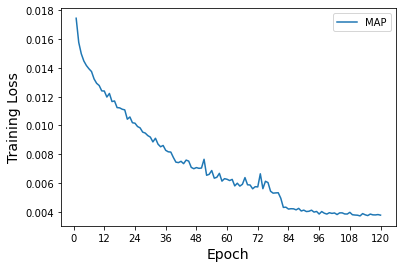

In [7]:
plot_losses("MAP", model.all_losses(), plt.subplot())